# Виявлення тексту

In [ ]:
from PIL import Image, ImageFilter
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from skimage.morphology import closing, square
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu


In [ ]:

class ImageProcessor:
    def __init__(self):
        pass

    def load_image(self, path):
        self.img = cv2.imread(path)
        return self.img

    def to_gray(self, img):
        return  cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    def contrast(self, img):
        img = img.copy()

        min_val = np.min(img)
        max_val = np.max(img)

        pixel_range = max_val - min_val

        img = (img - min_val) * (255.0 / pixel_range)
        img = np.round(img).astype(np.uint8)

        return img


    def as_white_background(self, im):
        colors = np.array(im).flatten()
        median = np.percentile(colors, 50)
        if median > 128:
            return im
        else:
            return 255 - im


    def get_histogram(self,im, horiz=False):
        if horiz:
            return np.array(im).mean(axis=0)
        else:
            return np.array(im).mean(axis=1)

    def get_hor_histogram(self,im):

        return np.array(im).sum(axis=(0, 1))


    def get_edges(self, im):
        if len(im.shape) > 2:
            im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

        edges = cv2.Canny(im, 100, 200)

        return edges

    def get_lines_positions(self, im, threshold=.002):
        hist = self.get_histogram(self.get_edges(im))
        threshold = hist.min() + threshold * (hist.max() - hist.min())

        height = hist.shape[0]
        lines = []

        pos = 0
        while True:
            while pos < height and hist[pos] < threshold: pos += 1
            if pos == height:
                break

            line_start = pos
            while pos < height and hist[pos] >= threshold: pos += 1
            line_end = pos
            lines.append((line_start, line_end))
            if pos == height:
                break

        lines = [i for i in lines if abs(i[0] - i[1]) > 5]
        return lines

    def get_words_positions(self,line, threshold=0.1, space_threshold=0.5):
        if len(line.shape) > 2:
            line = cv2.cvtColor(line, cv2.COLOR_BGR2GRAY)

        hist = self.get_histogram(line, horiz=True)
        threshold = hist.max() - threshold * (hist.max() - hist.min())

        h_hist = self.get_histogram(line)
        letters_height = h_hist / h_hist.mean() / 2
        letters_height = 1 - np.round(letters_height)
        letters_height = letters_height.sum()
        space_threshold = int(round(letters_height * space_threshold))
        width = hist.shape[0]
        words = []

        pos = 0
        while True:
            while pos < width and hist[pos] >= threshold: pos += 1
            if pos == width:
                break

            word_start = pos
            while pos < width and hist[pos] < threshold: pos += 1
            word_end = pos
            new_word = (word_start, word_end)
            if len(words) != 0:
                prev_words = words[-1]
                if word_start - prev_words[1] < space_threshold:
                    words[-1] = (words[-1][0], word_end)
                else:
                    words.append(new_word)
            else:
                words.append(new_word)

            if pos == width:
                break

        words = [i for i in words if abs(i[0] - i[1]) > 5]
        return words

    def crop_word(self, img, word):
        start,end = word
        cropped_word = img[:, start:end]

        return cropped_word


    def get_letters_positions(self, word_image):
        gray = cv2.cvtColor(word_image, cv2.COLOR_BGR2GRAY)
        _, threshold = cv2.threshold(gray, 90, 255, cv2.THRESH_BINARY_INV)
        
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
        dilated = cv2.dilate(threshold, kernel, iterations=1)

        labels = measure.label(dilated, connectivity=2, background=0)
        positions = []

        for label in np.unique(labels):
            if label == 0:
                continue

            mask = np.zeros(dilated.shape, dtype="uint8")
            mask[labels == label] = 255

            contours, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)
                if w > 2 and h > 10:
                    positions.append((x, y, w, h))

        return positions





    

In [ ]:
class TextRecognizer:
    def __init__(self, model, image_processor):
        self.model = model
        self.image_processor = image_processor
        self.ukr_alphabet = 'АБВГҐДЕЄЖЗИІЇЙКЛМНОПРСТУФХЦЧШЩЬЮЯабвгґдеєжзиіїйклмнопрстуфхцчшщьюя0987654321!"#%’()*+,-./:;'
        self.labels_to_letters = {i: self.ukr_alphabet[i] for i in range(len(self.ukr_alphabet))}


    def letter_to_class(self,letter):
        return self.ukr_alphabet.index(letter)

    def class_to_letter(self,cls):
        return self.labels_to_letters[cls]
    
    def crop_img(self,img):
        if img is None or img.size == 0:
            raise ValueError("Invalid input image")

        coords = np.column_stack(np.where(img > 0))

        if coords.size == 0:
            raise ValueError("No non-zero pixels found")

        # обчислюємо обмежувальний прямокутник для ненульових координат і обрізаємо зображення
        x_min, y_min = coords.min(axis=0)
        x_max, y_max = coords.max(axis=0)
        cropped_img = img[x_min:x_max+1, y_min:y_max+1]

        if cropped_img.size == 0:
            raise ValueError("Cropped image is empty")

        # Обчислюємо нові розміри зображення, зберігаючи співвідношення сторін
        height, width = cropped_img.shape[:2]
        if height > width:
            new_height = 28
            new_width = int(width * new_height / height)
        else:
            new_width = 28
            new_height = int(height * new_width / width)

        resized_img = cv2.resize(cropped_img, (new_width, new_height))

        if resized_img.size == 0:
            raise ValueError("Resized image is empty")

        # ширина і висота білих смуг, які потрібно додати
        padding_height = 28 - new_height
        padding_width = 28 - new_width

        if padding_height < 0 or padding_width < 0:
            raise ValueError("Padding is negative. Check the resized image dimensions.")

        top_border_height = padding_height // 2
        bottom_border_height = padding_height - top_border_height

        left_border_width = padding_width // 2
        right_border_width = padding_width - left_border_width

        padded_img = cv2.copyMakeBorder(resized_img, top_border_height, bottom_border_height,
                                        left_border_width, right_border_width, cv2.BORDER_CONSTANT, value=255)
        padded_img = cv2.bitwise_not(padded_img)

        return padded_img
    
    def preprocess_image(self,image):
        image = cv2.resize(image, (28, 28))

        if len(image.shape) > 2 and image.shape[2] > 1:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        image = np.reshape(image, (28, 28, 1))

        image = image / 255.0
        return image


    def predict_letter(self, image):
        # plt.imshow(image)
        # plt.show()

        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = self.preprocess_image(image)

        # ----------------
        prediction = self.model.predict(np.array([image]))
        predicted_class = np.argmax(prediction)
        predicted_letter = self.class_to_letter(predicted_class)

        return predicted_letter


    def predict_letters(self, word_image):
        letters_images_resized = []
        letters_positions = self.image_processor.get_letters_positions(word_image)

        for pos in letters_positions:
            x, y, w, h = pos
            letter_img = word_image[y:y+h, x:x+w]


            letter_img = cv2.cvtColor(letter_img, cv2.COLOR_BGR2GRAY)
            
            letter_img = self.crop_img(letter_img)
            letter_img = 255 - letter_img
            letter_img = self.preprocess_image(letter_img)

            if len(letter_img.shape) > 2 and letter_img.shape[2] == 3:
                gray_img = cv2.cvtColor(letter_img, cv2.COLOR_BGR2GRAY)
            else:
                gray_img = letter_img
                
            letters_images_resized.append(gray_img[..., np.newaxis])  


        if letters_images_resized:
            letters_images_array = np.stack(letters_images_resized, axis=0)
        else:
            return ''

        predictions = self.model.predict(letters_images_array)

        predicted_classes = [np.argmax(p) for p in predictions] 
        predicted_letters = [self.class_to_letter(c) for c in predicted_classes]


        return predicted_letters



    def recognize_text(self, image):

        self.image_processor.gray = image
        self.image_processor.gray = self.image_processor.contrast(self.image_processor.gray)
        self.image_processor.gray = self.image_processor.as_white_background(self.image_processor.gray)
        lines = self.image_processor.get_lines_positions(self.image_processor.gray)

        text = ""
        for line in lines:
            start, end = line
            line_image = self.image_processor.gray[start:end]
            # plt.imshow(line_image)
            # plt.show()

            words = self.image_processor.get_words_positions(line_image)

            for word in words:

                word_image = self.image_processor.crop_word(line_image, word)

                letter_predictions = self.predict_letters(word_image)
                word_text = "".join(letter_predictions)
                text += word_text + " "  
            text += "\n"  
        return text


## Тестуємо роботу класів

### Тестуємо роботу ImageProcessor

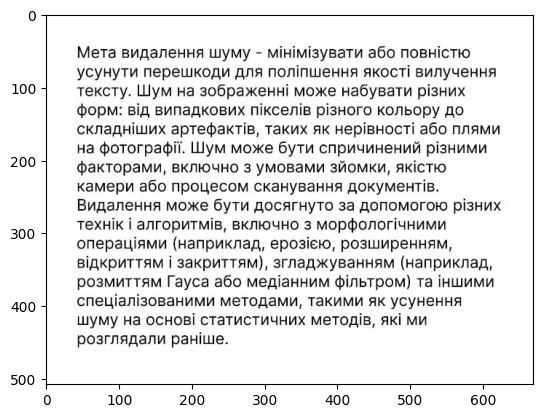

Line positions: [(44, 65), (70, 92), (96, 118), (122, 144), (148, 170), (175, 196), (201, 223), (227, 249), (253, 275), (279, 301), (305, 327), (332, 354), (358, 380), (388, 406), (414, 432), (441, 458)]


In [ ]:
import cv2
import matplotlib.pyplot as plt

processor = ImageProcessor()

image = cv2.imread('/content/noise.png')

# Застосовуємо методи класу ImageProcessor до зображення
processed_image = processor.contrast(image)
processed_image = processor.as_white_background(processed_image)
lines = processor.get_lines_positions(processed_image)
# words = processor.get_words_positions(processed_image)

plt.imshow(processed_image, cmap='gray')
plt.show()


print("Line positions:", lines)
# print("Word positions:", words)


Line 1


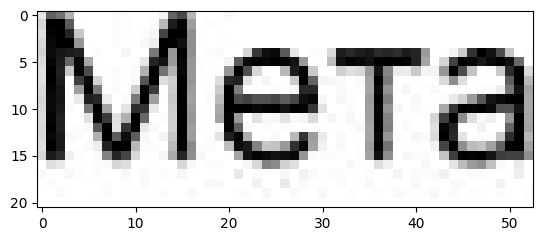

Line 1


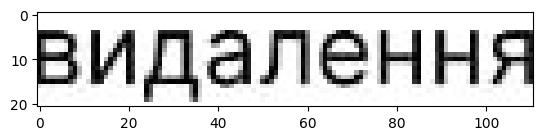

Line 1


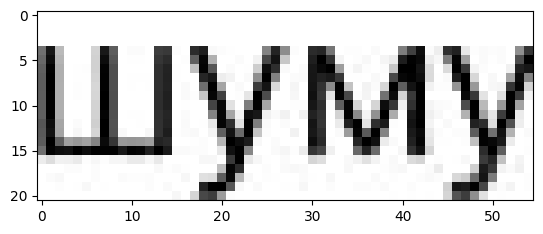

Line 1


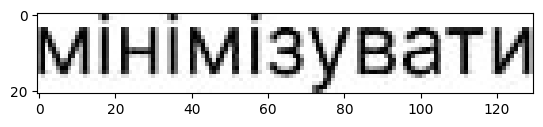

Line 1


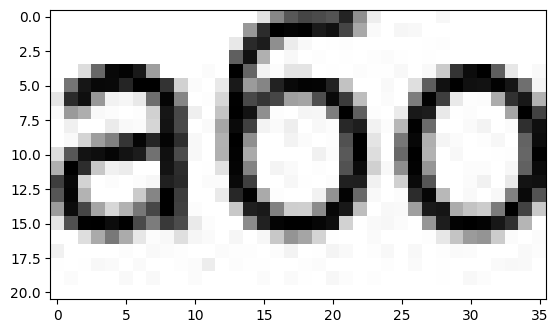

Line 1


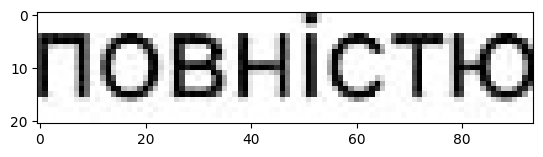

Line 2


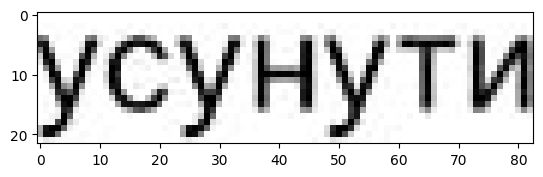

Line 2


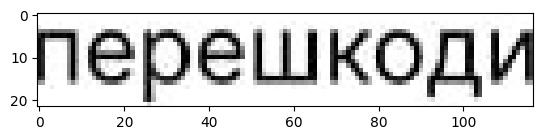

Line 2


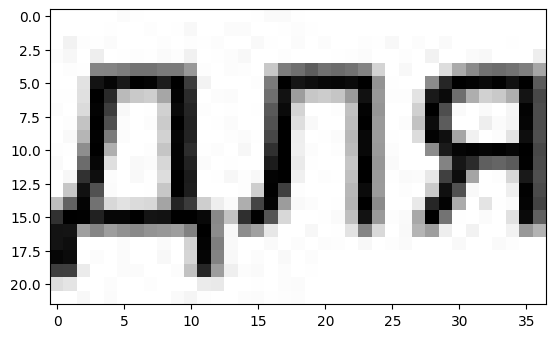

Line 2


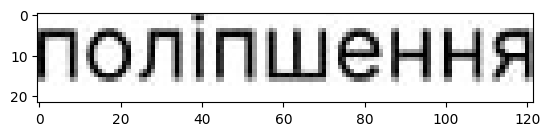

Line 2


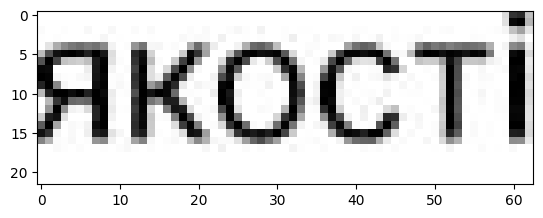

Line 2


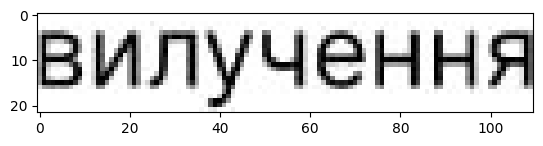

Line 3


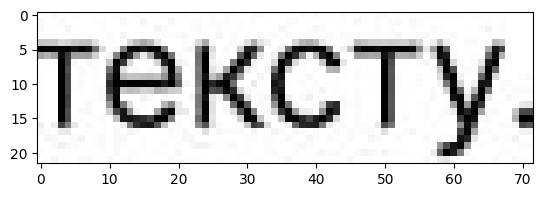

Line 3


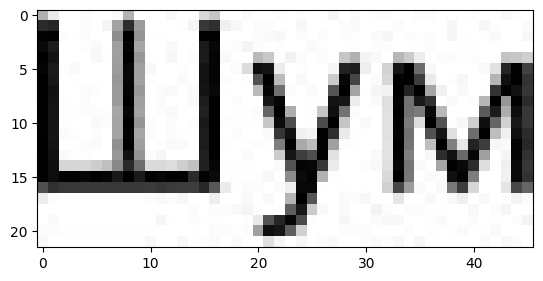

Line 3


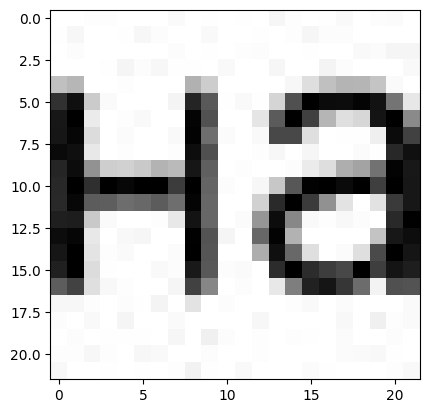

Line 3


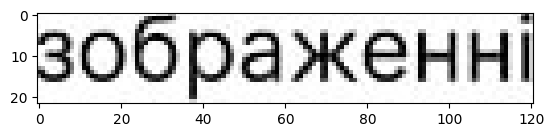

Line 3


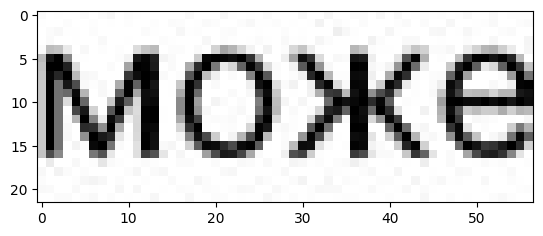

Line 3


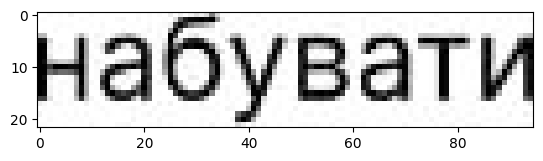

Line 3


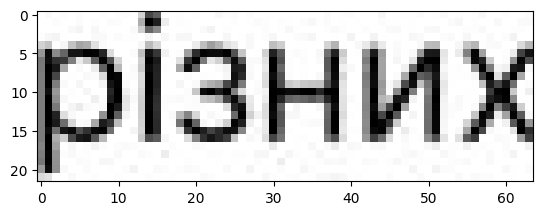

Line 4


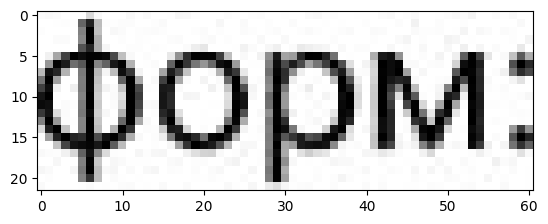

Line 4


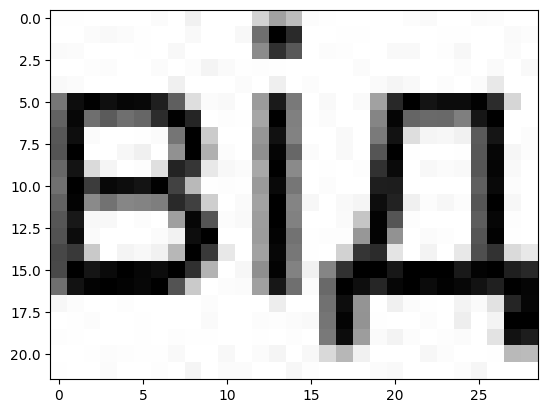

Line 4


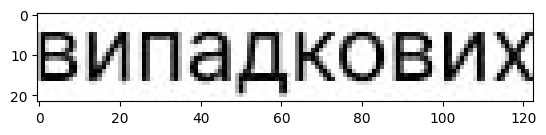

Line 4


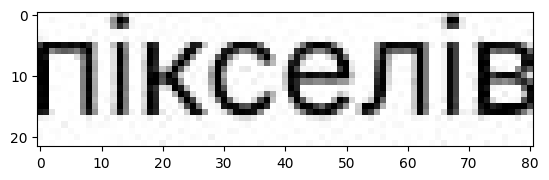

Line 4


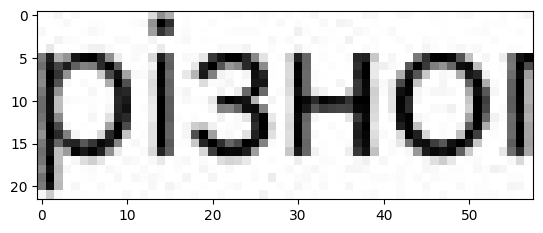

Line 4


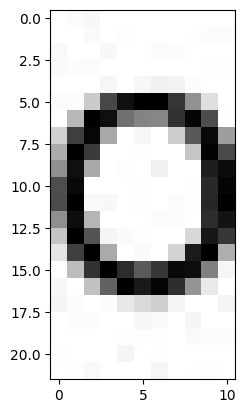

Line 4


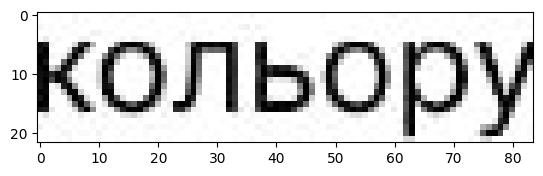

Line 4


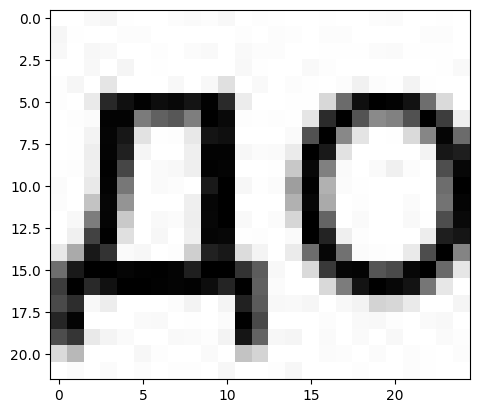

Line 5


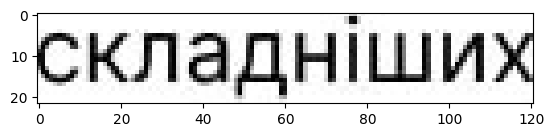

Line 5


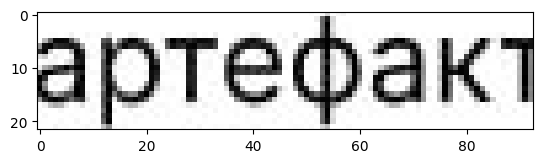

Line 5


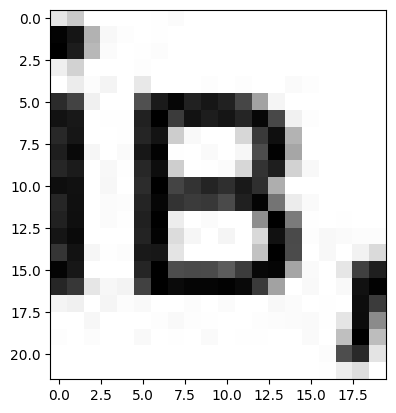

Line 5


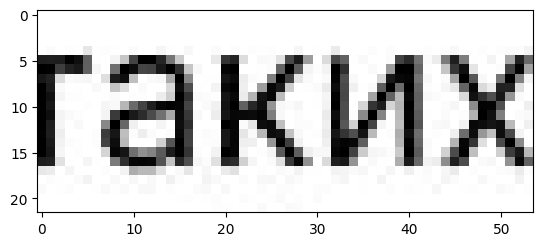

Line 5


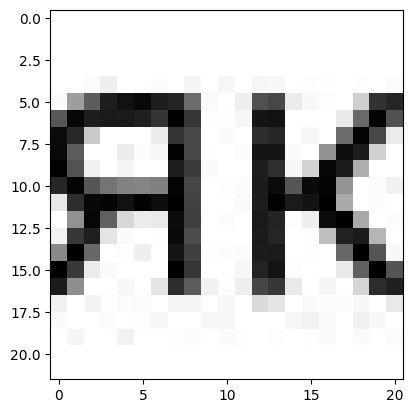

Line 5


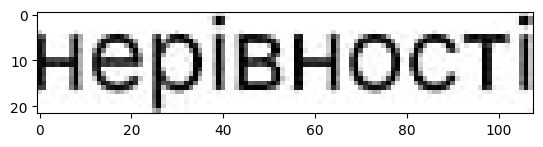

Line 5


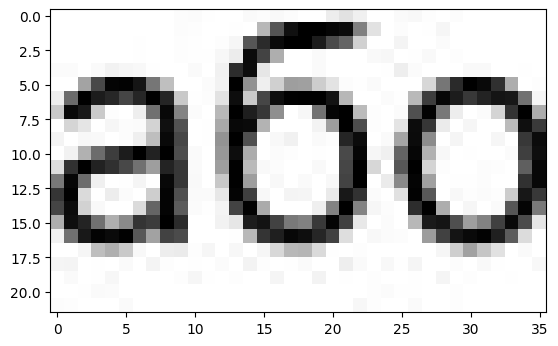

Line 5


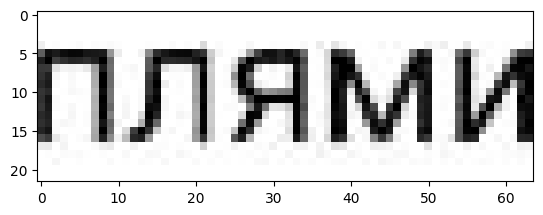

Line 6


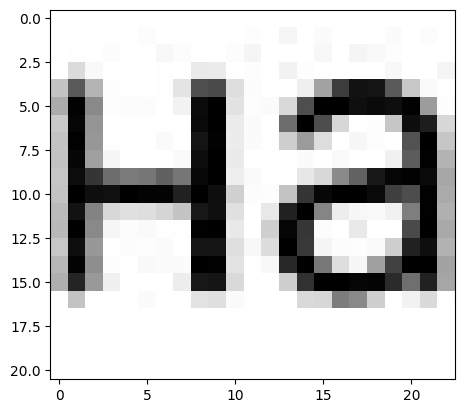

Line 6


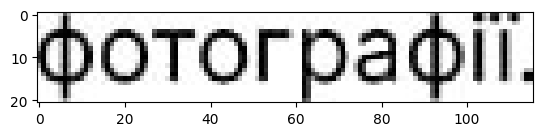

Line 6


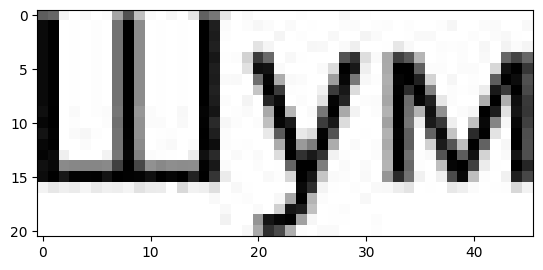

Line 6


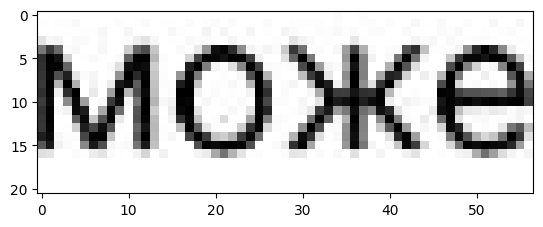

Line 6


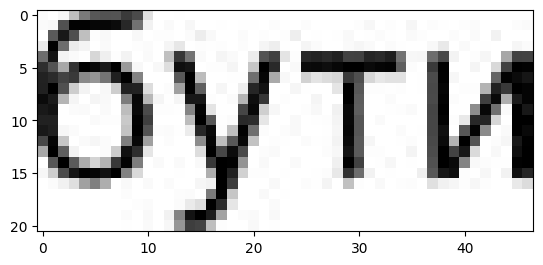

Line 6


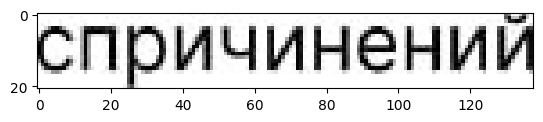

Line 6


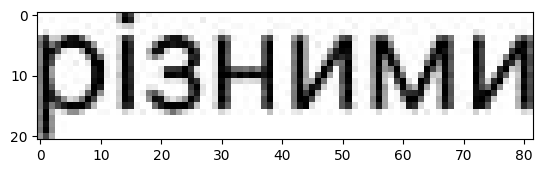

Line 7


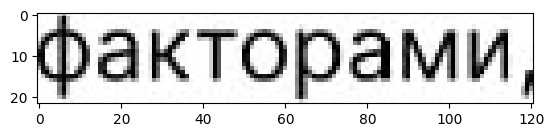

Line 7


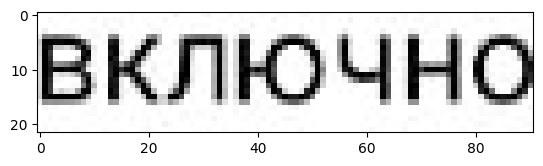

Line 7


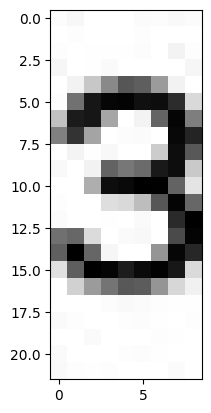

Line 7


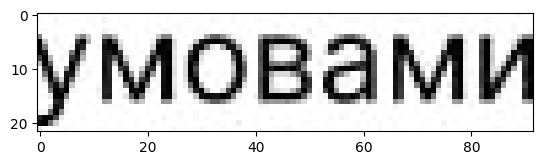

Line 7


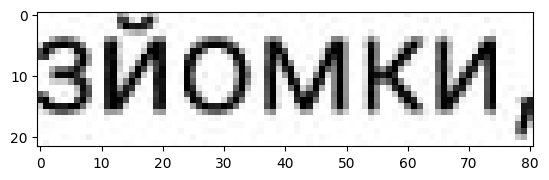

Line 7


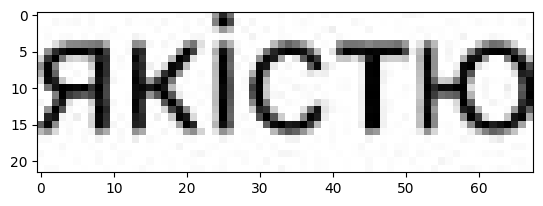

Line 8


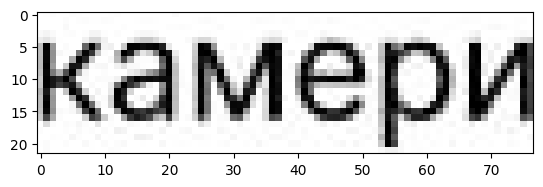

Line 8


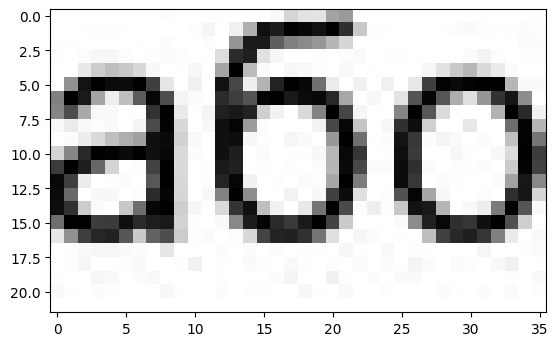

Line 8


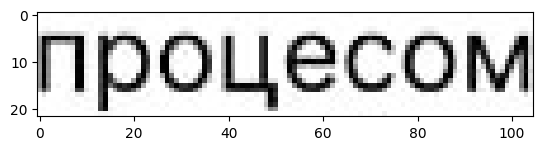

Line 8


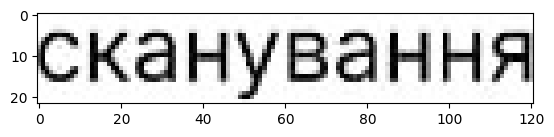

Line 8


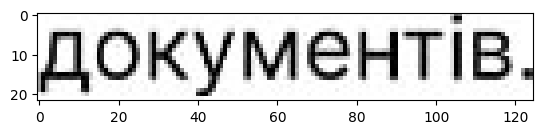

Line 9


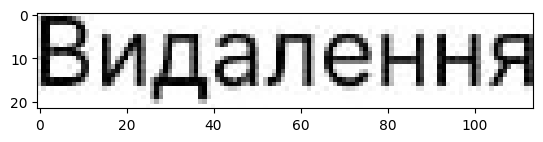

Line 9


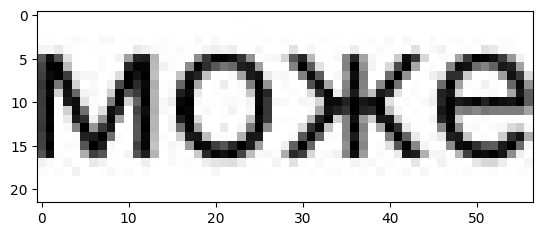

Line 9


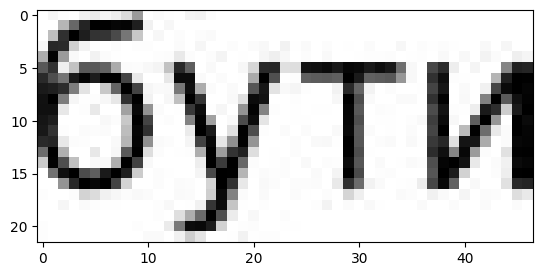

Line 9


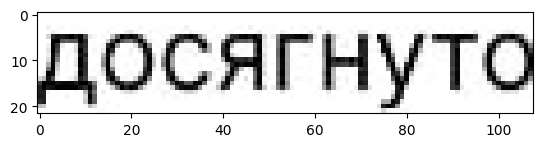

Line 9


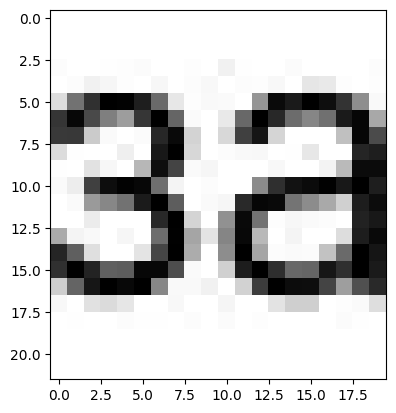

Line 9


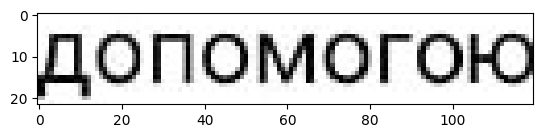

Line 9


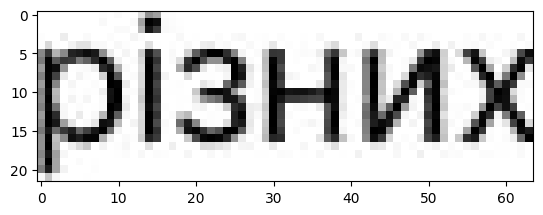

Line 10


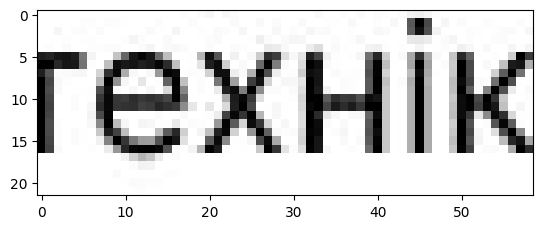

Line 10


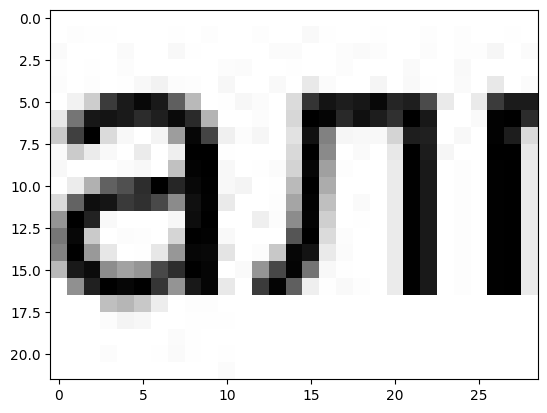

Line 10


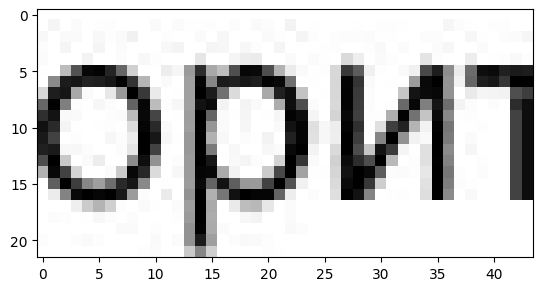

Line 10


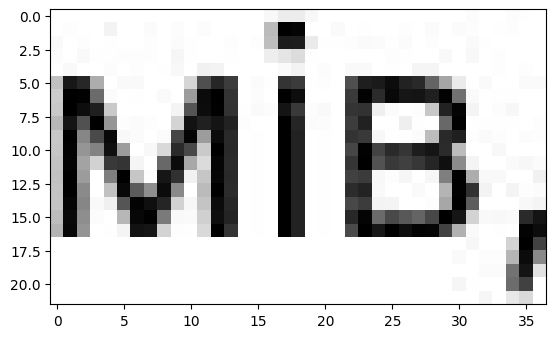

Line 10


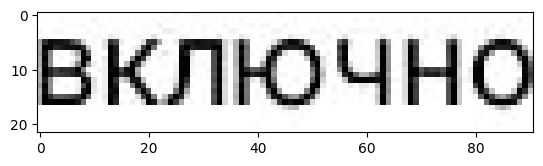

Line 10


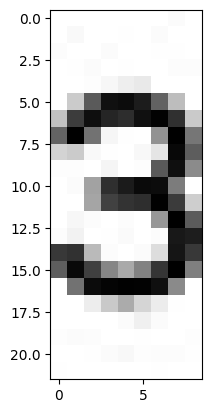

Line 10


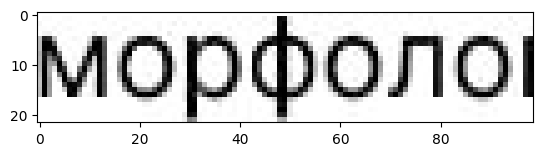

Line 10


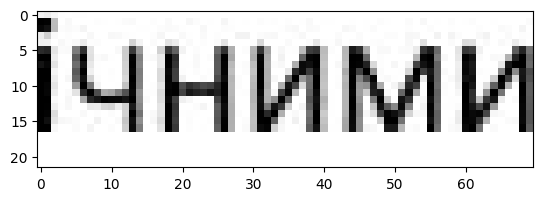

Line 11


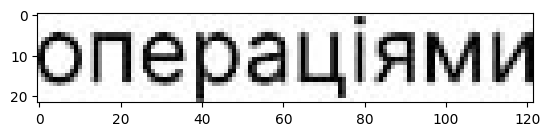

Line 11


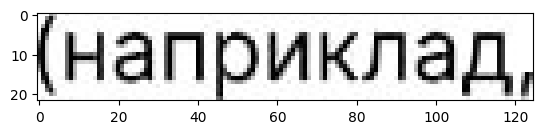

Line 11


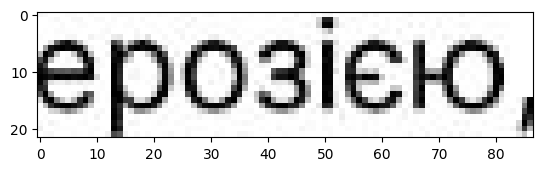

Line 11


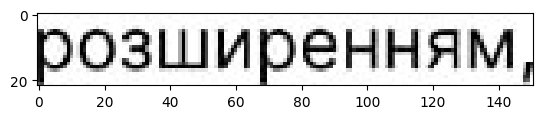

Line 12


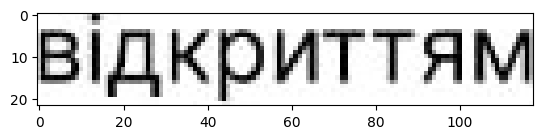

Line 12


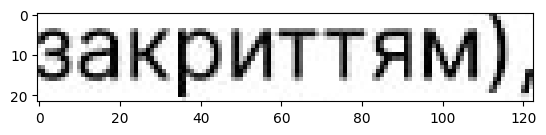

Line 12


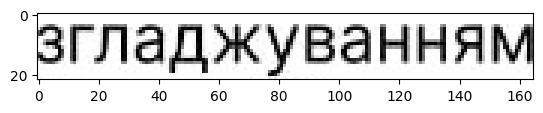

Line 12


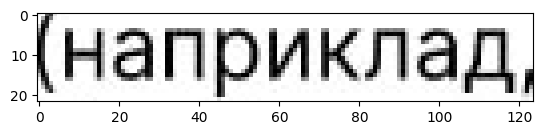

Line 13


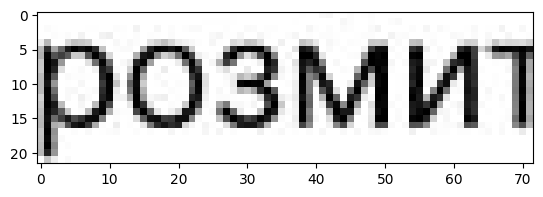

Line 13


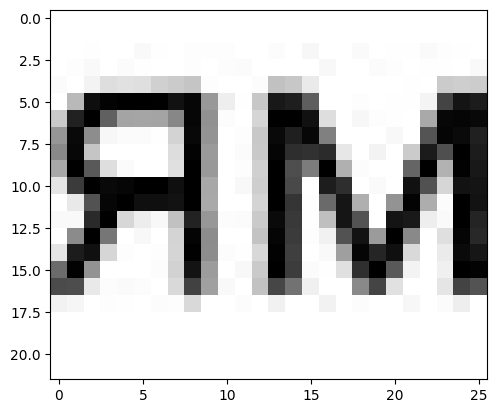

Line 13


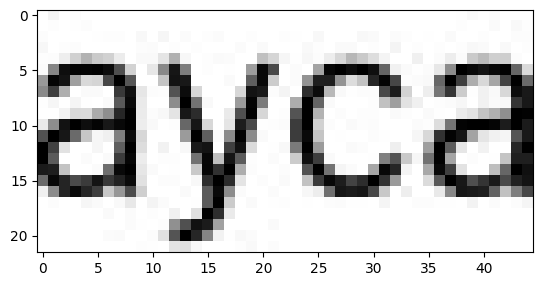

Line 13


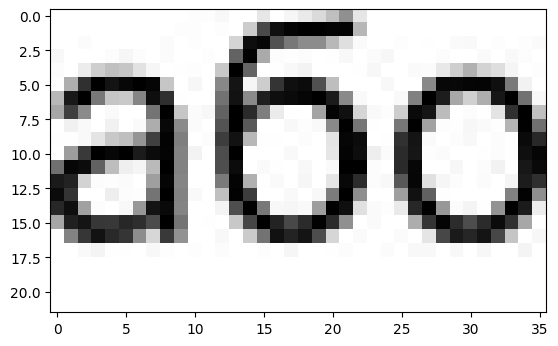

Line 13


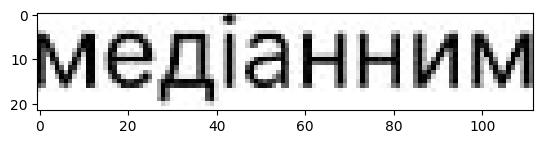

Line 13


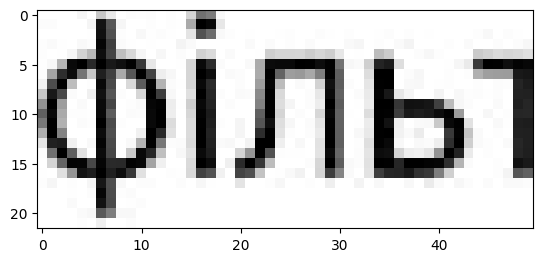

Line 13


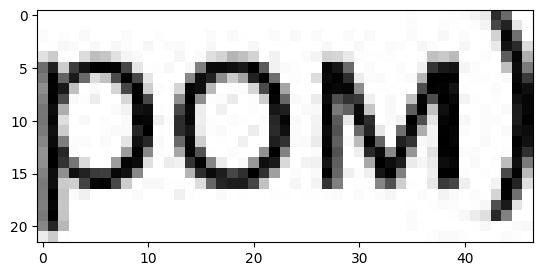

Line 13


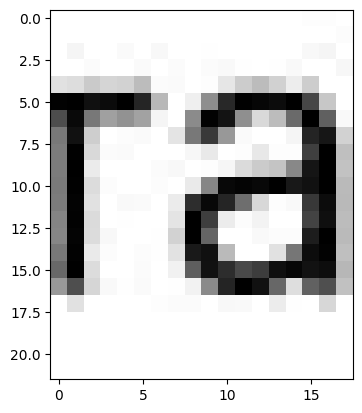

Line 13


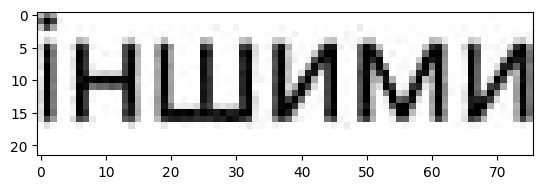

Line 14


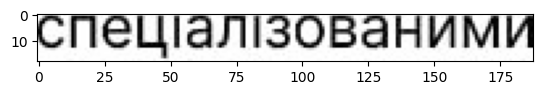

Line 14


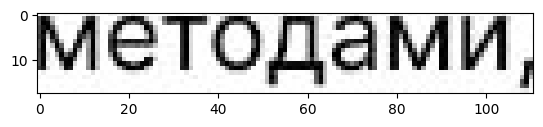

Line 14


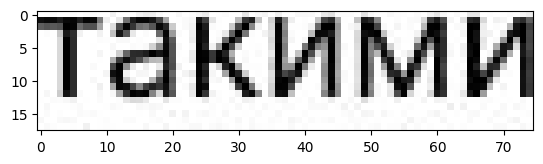

Line 14


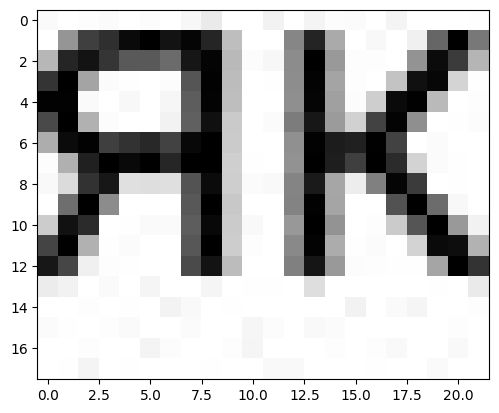

Line 14


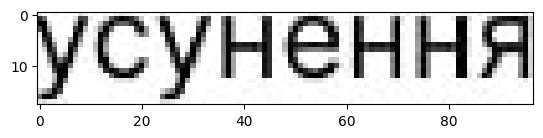

Line 15


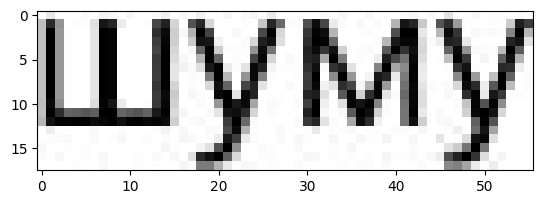

Line 15


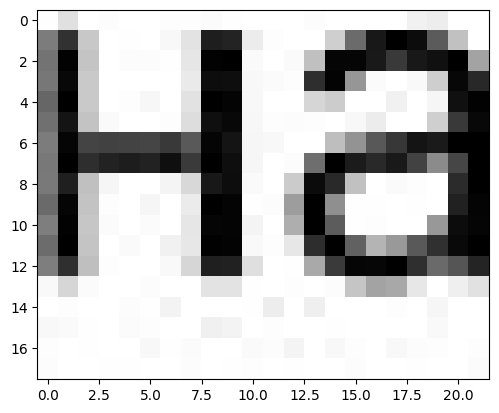

Line 15


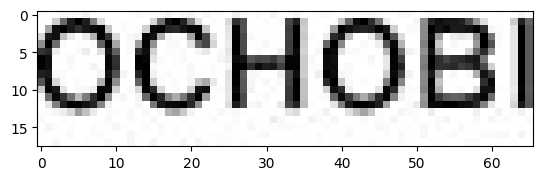

Line 15


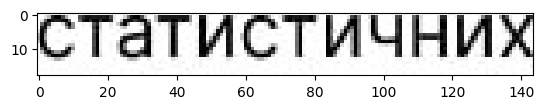

Line 15


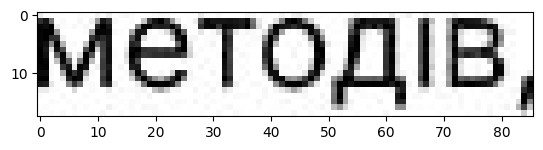

Line 15


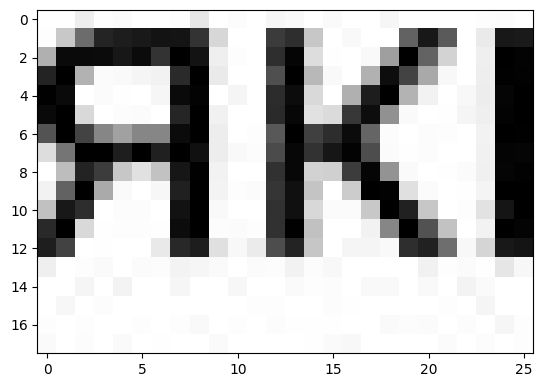

Line 15


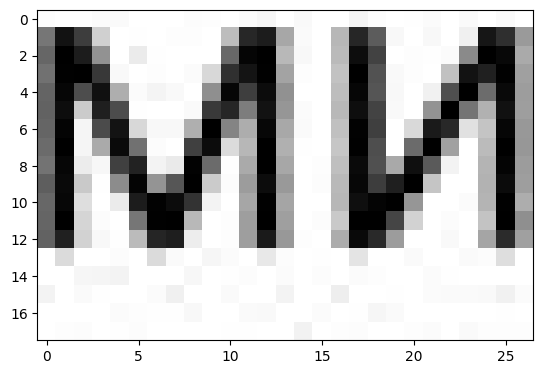

Line 16


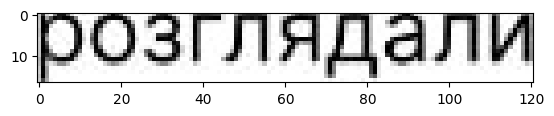

Line 16


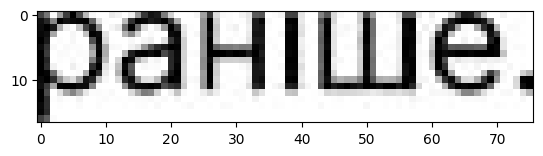

In [ ]:


for i, line in enumerate(lines):
    start, end = line
    line_image = processed_image[start:end]
    words_in_line = processor.get_words_positions(line_image)
    
    for j, word in enumerate(words_in_line):
        start, end = word
        word_image = line_image[:, start:end]
        print(f'Line {i+1}')
        plt.imshow(word_image)
        plt.show()
        


### Тестируем работу  TextRecognizer

In [ ]:
from tensorflow.keras.models import load_model
import time 
start = time.time()

model = load_model('last_one.h5')



processor = ImageProcessor()
recognizer = TextRecognizer(model,processor)

image = cv2.imread('/content/noise.png')
# image = cv2.imread('/content/tet.jpg')



res = recognizer.recognize_text(image)


end = time.time() - start

print(end) 



1/1 [==============================] - 0s 209ms/step
['М', 'е', 'Т', 'В']
1/1 [==============================] - 0s 173ms/step
['В', 'И', 'Д', 'В', 'Л', 'е', 'Н', 'Н', 'Я']
1/1 [==============================] - 0s 88ms/step
['Щ', 'У', 'М', 'У']
1/1 [==============================] - 0s 216ms/step
['М', 'І', 'Н', 'І', 'М', 'І', 'З', 'У', 'В', 'В', 'Т', 'И']
1/1 [==============================] - 0s 74ms/step
['б', 'В', 'О']
1/1 [==============================] - 0s 147ms/step
['П', 'О', 'В', 'Н', 'І', 'С', 'Т', 'Ю']
1/1 [==============================] - 0s 133ms/step
['У', 'С', 'У', 'Н', 'У', 'Т', 'И']
1/1 [==============================] - 0s 160ms/step
['П', 'е', 'р', 'е', 'Щ', 'К', 'О', 'Д', 'И']
1/1 [==============================] - 0s 102ms/step
['Д', 'Л', 'Я']
1/1 [==============================] - 0s 97ms/step
['П', 'О', 'Л', 'І', 'П', 'Щ', 'е', 'Н', 'Н', 'Я']
1/1 [==============================] - 0s 63ms/step
['Я', 'К', 'О', 'С', 'Т', 'І']
1/1 [==============================

In [ ]:
print(res)

  
 
рОЗПІЗНЗТИ ТЕКСТ НЗ ВЗШИХ 
бЗОрЗЖЕННЯХ ПрОСТО НЗДІШЛІТЬ МЄНА 
бЗОрЗЖЕННЯ І бВИЕрІТЬ ОДНУ З 
МОЦЕЛЕИ ЩЯ ІєрОЗПІЗНЗВЗННЯ 



In [ ]:
# Навчена модель після аугментації даних 
print(res)

  
 
рОЗПиЗНаТИ ТеКСТ На ВаШИХ 
бЗОраЖеННЯХ ПрОСТО НаДиШЛиТЬ МеНи 
бЗОраЖеННЯ и бВИериТЬ ОДНу З 
МОДеЛеИ рЯ ІирОЗПиЗНаВаННЯ 



In [ ]:
print(res)

  
 
цОЗПІЗННТИ ТЄКСЇ НН ВдШИХ 
бЗОцНЖЄННЯХ ПцОСТО НдДІШЛіТЬ МЄНІ 
бЗОрНЖЄННЯ І бВИЄрІТЬ ОДНУ З 
МОДЄЛЄИ ЩЯ ІацОЗПІЗНдВдННЯ 



In [ ]:
print('Покращена CNN модель з аугментацією даний навчена на 26 епохах')
print(res)


Покращена CNN модель з аугментацією даний навчена на 26 епохах
  
 
рОЗПШЗНВТИ ТЗКСТ НВ ВВШИХ 
бЗОрВЖЗННЯХ ПрОСТО НВДШШЛШТЬ ЙЗНШ 
бЗОрВЖЗННЯ Ш бВИЗрШТЬ ОДНУ З 
ЙОДЗЛЗИ ЩЯ ШШрОЗПШЗНВВВННЯ 



In [ ]:
print('Покращена CNN модель з більш слабкою аугментацією даний навчена на 20 епохах')
print(res)

Покращена CNN модель з більш слабкою аугментацією даний навчена на 20 епохах
  
 
рОЗПІЗНЗТИ ТеКСТ НЗ ВЗшИХ 
бЗОрЗЖеННЯХ ПрОСТО НЗДІшЛІТЬ МеНІ 
бЗОрЗЖеННЯ І бВИерІТЬ ОДНу З 
МОДеЛеИ щЯ ІІрОЗПІЗНЗВЗННЯ 



In [ ]:
print('Покращена CNN модель з більш слабкою аугментацією даний навчена на 20 епохах:\n')
print(res.lower())

Покращена CNN модель з більш слабкою аугментацією даний навчена на 20 епохах:

мета видалення шуму  мінімізувати бао повністю 
усунути перешкоди для поліпшення якості вилучення 
тексту шум на бзораженні може бнаувати різних 
форм від випадкових пікселів різноі о кольору до 
складніших фартеак іві гаких як нерівнос бао плями 
на фотоі фраіі шум може бу и спричинении різними 
фак горамиі включно з умовами зиомкиі якістю 
камери бао процесом сканування документів 
видалення може бути досягнуто за допомогою різних 
гехнік алі орит міві включно з фморолоі ічними 
операціями інаприкладі ерозієюі розширеннямі 
відкриттям їзакриттямі згладжуванням інаприкладі 
розмит ям ауса бао медіанним фільт їром га іншими 
спеціалізованими методамиі такими як усунення 
шуму на основі статистичних методіві які ми 
розглядали раніше 



In [ ]:
print('Звичайна CNN модель з більш слабкою аугментацією даний навчена на 10 епохах:\n')
print(res.lower())

Звичайна CNN модель з більш слабкою аугментацією даний навчена на 10 епохах:

иетв видвленни шуиу  ифнфифзуввти бво повнфстю 
усунути перешкоди дли полфпшенни икостф вилученни 
тексту шуи нв ьзорвженнф иоже бнвуввти рфзних 
фори вфд випвдкових пфксепфв рфзноф о кольору до 
склвднфших фвртевк фві гвких ик нерфвнос бво плиии 
нв фотоф фрвфї шуи иоже бу и спричинении рфзниии 
фвк горвииі вкпючно з уиоввии зиоикиі икфстю 
квиери бво процесои сквнуввнни докуиентфв 
видвпенни иоже бути досигнуто зв допоиогою рфзних 
гехнфк впф орич ифві вкпючно з фиоролоф фчниии 
опервцфиии фнвприклвді ерозфєюі розширеннииі 
вфдкриттии фзвкриттииі зглвджуввннии фнвприклвді 
розиич ии вусв бво иедфвннии ффльч фрои гв фншиии 
спецфвпфзоввниии иетодвииі твкиии ик усуненни 
шуиу нв основф ствтистичних иетодфві икф ии 
розгпидвли рвнфше 



In [ ]:
print('CNN модель(4) з більш слабкою аугментацією даних навчена на 19 епохах:\n')
print(res.lower())

CNN модель(4) з більш слабкою аугментацією даних навчена на 19 епохах:

иетв видвленни шуиу  ифнфифзуввти бво повнфстю 
усунути перешкоди дли полфпшенни икостф вилученни 
тексту шуи нв ьзорвженнф иоже бнвуввти рфзних 
фори вфд випвдкових пфксепфв рфзноф о кольору до 
склвднфших фвртевк фві гвких ик нерфвнос бво плиии 
нв фотоф фрвфї шуи иоже бу и спричинении рфзниии 
фвк горвииі вкпючно з уиоввии зиоикиі икфстю 
квиери бво процесои сквнуввнни докуиентфв 
видвпенни иоже бути досигнуто зв допоиогою рфзних 
гехнфк впф орич ифві вкпючно з фиоролоф фчниии 
опервцфиии фнвприклвді ерозфєюі розширеннииі 
вфдкриттии фзвкриттииі зглвджуввннии фнвприклвді 
розиич ии вусв бво иедфвннии ффльч фрои гв фншиии 
спецфвпфзоввниии иетодвииі твкиии ик усуненни 
шуиу нв основф ствтистичних иетодфві икф ии 
розгпидвли рвнфше 



In [ ]:
print(res.lower())

метв видвлення щуму  мінімізуввти бво повністю 
усунути перещкоди для поліпщення якості вилучення 
тексту шум нв бзорвженні можє бнвуввти різних 
форм від випвдкових пікселів різноі о кольору до 
склвдніщих фвртевк іві гвких як нерівнос бво плями 
нв фотоі фрвіі шум може бу и спричинении різними 
фвк горвмиі включно з умоввми зиомкиі якістю 
квмери бво процесом сквнуввння документів 
видвлення може бути досягнуто зв допомогою різних 
гехнік влі орил міві включно з фморолоі ічними 
опервціями інвприклвді ерозієюі розщиреннямі 
відкриттям ізвкриттямі зглвджуввнням інвприклвді 
розмиі ям вусв бво медівнним фільл іром гв інщими 
спецівлізоввними методвмиі твкими як усунення 
щуму нв основі ствтистичних методіві які ми 
розглядвли рвніще 

